![title](raintaxi.jpg)

conda install -c anaconda seaborn=0.7.1

In [102]:
import pandas as pd
import thinkstats2 as ts2
import thinkplot as tp
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import math
import seaborn as sns
from bokeh.io import output_notebook
%matplotlib inline

### For completeness, the MapReduce jar:

// cc YTtrips Application
// vv YTtrips
import org.apache.hadoop.fs.Path;
import org.apache.hadoop.io.IntWritable;
import org.apache.hadoop.io.DoubleWritable;
import org.apache.hadoop.io.Text;
import org.apache.hadoop.mapreduce.Job;
import org.apache.hadoop.mapreduce.lib.input.FileInputFormat;
import org.apache.hadoop.mapreduce.lib.output.FileOutputFormat;
public class YTtrips 
{
    public static void main(String[] args) throws Exception 
    {
        if (args.length != 2) 
        {
            System.err.println("Usage: YTtrips <input path> <output path>");
            System.exit(-1);
        }

        Job job = new Job();
        job.setJarByClass(YTtrips.class);
        job.setJobName("YTtrips");
        FileInputFormat.addInputPath(job, new Path(args[0]));
        FileOutputFormat.setOutputPath(job, new Path(args[1]));
        job.setMapperClass(YTtripsMapper.class);
        job.setReducerClass(YTtripsReducer.class);
        job.setOutputKeyClass(Text.class);
        job.setOutputValueClass(DoubleWritable.class);
        System.exit(job.waitForCompletion(true) ? 0 : 1);
    }
}
// ^^ YTtrips

// cc YTtripsMapper
import java.io.IOException;
import org.apache.hadoop.io.IntWritable;
import org.apache.hadoop.io.DoubleWritable;
import org.apache.hadoop.io.LongWritable;
import org.apache.hadoop.io.Text;
import org.apache.hadoop.mapreduce.Mapper;
public class YTtripsMapper
    extends Mapper<LongWritable, Text, Text, DoubleWritable> 
    {
        @Override
        public void map(LongWritable key, Text value, Context context)
        throws IOException, InterruptedException 
        {
            String line = value.toString();
            String comma = ",";
            String[] parsedLine = line.split(comma);
            
            if((parsedLine.length == 18)||(parsedLine.length==19))
            {
                //Format date-time beginning of trip.
                String start = parsedLine[1].substring(0,10);
                String[] startDate = start.split("-");
                String startYear = startDate[0];
                String startMonth = startDate[1];
                String startDay = startDate[2];

                String passengers = parsedLine[3];
                String distance = parsedLine[4];
           
                if((Integer.parseInt(passengers)<=9)&&(Integer.parseInt(passengers)>0)&&(Double.parseDouble(distance)<=100)&&(Double.parseDouble(distance)>0))
                {
                    String newKey;
                    double newValue;

                    newKey = startYear+"/"+startMonth+"/"+startDay;
                    newValue = Integer.parseInt(parsedLine[3])*Double.parseDouble(parsedLine[4]);
                
                    context.write(new Text(newKey), new DoubleWritable(newValue));
                }
                    else{}
            }
                else{}
        }
    }

// cc YTtripsReducer Reducer for trip count and passenger miles traveled by day.
// vv YTtripsReducer
import java.io.IOException;
import org.apache.hadoop.io.IntWritable;
import org.apache.hadoop.io.DoubleWritable;
import org.apache.hadoop.io.Text;
import org.apache.hadoop.mapreduce.Reducer;
public class YTtripsReducer
    extends Reducer<Text, DoubleWritable, Text, Text> 
    {
    @Override
        public void reduce(Text key, Iterable<DoubleWritable> values, Context context)
        throws IOException, InterruptedException 
        {
            int count = 0;
            double passengerMiles = 0;

            String newValue;
            for (DoubleWritable value : values) 
            {
                count++;
                passengerMiles = passengerMiles+value.get();
            }

            long pmt = Math.round(passengerMiles);
            newValue = ","+String.valueOf(count)+","+String.valueOf(pmt);
            context.write(key, new Text(newValue));
        }
    }

In [103]:
dataframe = pd.read_csv("final_df.csv")

In [104]:
dataframe.columns = ['date', 'rain', 'snowdepth', 'snow', 'weekday', 'weekend', 'holidays', 'trips', 'pmt', 'entries']

In [105]:
df = dataframe[dataframe.pmt>0]
mta = dataframe[dataframe.entries>0]

In [106]:
df["date"]=pd.to_datetime(df.date, infer_datetime_format=True)
mta["date"]=pd.to_datetime(mta.date, infer_datetime_format=True)

C:\Users\J.X\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\J.X\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [107]:
class CorrelationPermuate(ts2.HypothesisTest):
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(ts2.Corr(xs, ys))
        return test_stat
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

class CovariancePermutate(ts2.HypothesisTest):    
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(ts2.Cov(xs, ys))
        return test_stat
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys
    
class DiffMeansPermutate(ts2.HypothesisTest):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

## Model the variables.

In [108]:
from bokeh.charts import Histogram, show

hist = Histogram(df, values='pmt', title="Histogram for Passenger Miles Traveled", color='purple', bins=25, plot_width=800)

output_notebook()
show(hist)

Loading BokehJS ...

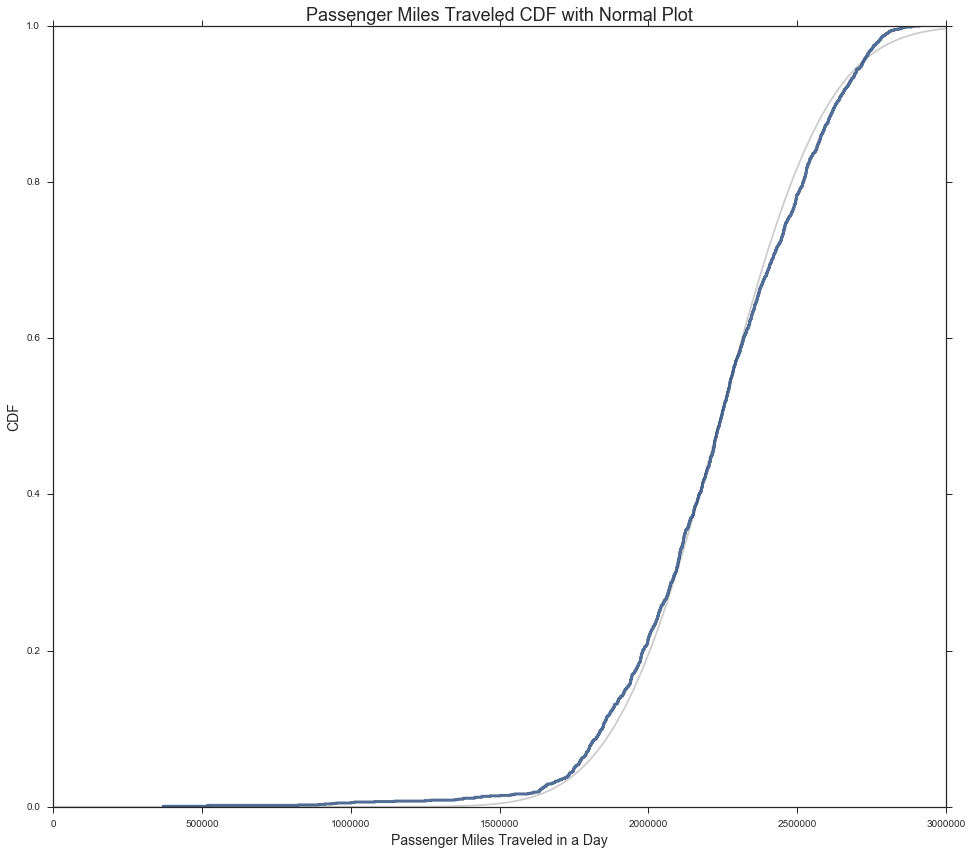

In [109]:
data1 = df.pmt
mu1, var1 = ts2.TrimmedMeanVar(data1, p=0.01)

# plot the models
sigma1 = math.sqrt(var1)
xs1, ps1 = ts2.RenderNormalCdf(mu1, sigma1, low=0, high=3000000)
pmt_cdf = ts2.Cdf(data1)

plt.figure(figsize=(16,14))
plt.plot(xs1, ps1, color='0.8')

#parameters for the resulting graph:
plt.title("Passenger Miles Traveled CDF with Normal Plot", fontsize=18)
plt.xlabel("Passenger Miles Traveled in a Day", fontsize=14)
plt.ylabel("CDF", fontsize=14)
# plot the data
tp.Cdf(pmt_cdf)
plt.show()

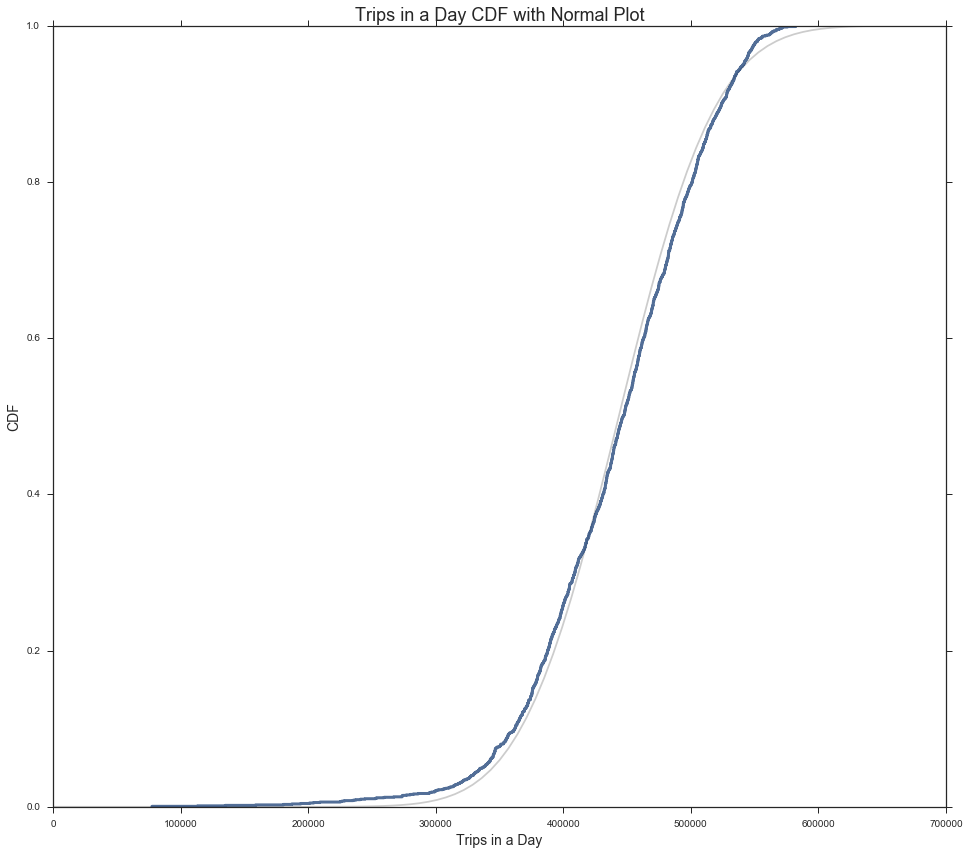

In [110]:
data1 = df.trips
mu1, var1 = ts2.TrimmedMeanVar(data1, p=0.01)

# plot the models
sigma1 = math.sqrt(var1)
xs1, ps1 = ts2.RenderNormalCdf(mu1, sigma1, low=0, high=700000)
pmt_cdf = ts2.Cdf(data1)

plt.figure(figsize=(16,14))
plt.plot(xs1, ps1, color='0.8')

#parameters for the resulting graph:
plt.title("Trips in a Day CDF with Normal Plot", fontsize=18)
plt.xlabel("Trips in a Day", fontsize=14)
plt.ylabel("CDF", fontsize=14)
# plot the data
tp.Cdf(pmt_cdf)
plt.show()

In [111]:
plt.figure(figsize=(16,14))
rain = df.rain
hist = Histogram(rain, values='rain', title="Rain Histogram", xlabel='Inches of Rain', ylabel="Count of Days with Amount", color='blue', bins=30, plot_width=800)


show(hist)

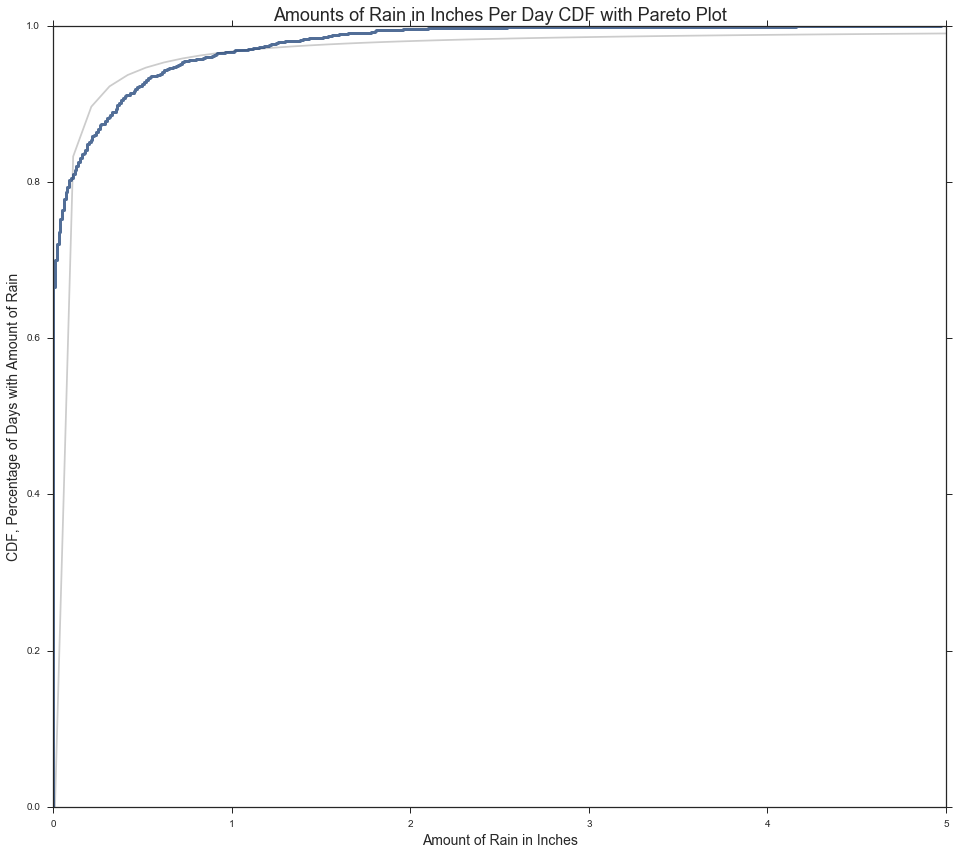

4.97


In [112]:
data1 = df.rain
mu1, var1 = ts2.TrimmedMeanVar(data1, p=0.01)
high = max(df.rain)

# plot the models
sigma1 = math.sqrt(var1)
xs1, ps1 = ts2.RenderParetoCdf(xmin=0.01, alpha=0.74, low=0, high=5.0)
pmt_cdf = ts2.Cdf(data1)

plt.figure(figsize=(16,14))
plt.plot(xs1, ps1, color='0.8')

# parameters for the resulting graph:
plt.title("Amounts of Rain in Inches Per Day CDF with Pareto Plot", fontsize=18)
plt.xlabel("Amount of Rain in Inches", fontsize=14)
plt.ylabel("CDF, Percentage of Days with Amount of Rain", fontsize=14)

# plot the data
tp.Cdf(pmt_cdf)
plt.show()
print(high)

# Hypothesis: Rain does affect in some way either the number of passenger miles traveled or the number of trips.
### First, by permutation of the two samples, it is possible to check whether this is a statistically significant difference between their means. This is the simplest test we can undertake.

In [113]:
rain = df[df.rain>0].pmt
clear = df[df.rain==0].pmt
data = rain, clear
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = abs(rain.mean()-clear.mean())
print(difference_in_means)
print(pvalue)

41553.328787924256
0.008


In [114]:
rain = df[df.rain>0].trips
clear = df[df.rain==0].trips
data = rain, clear
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = abs(rain.mean()-clear.mean())
print(difference_in_means)
print(pvalue)

1280.759827574133
0.73


### There is a statistically significant difference between the means for days with and without rain when using passenger miles traveled, despite the lack of a statistically significant difference in the mean for number of trips. This suggests that the number of passengers in taxis changes when it rains, despite the lack of change in the number of trips.

# Check the differences between the means for weekdays and weekends:

In [115]:
import pandas as pd

from bokeh.charts import TimeSeries, show

data = dict(date=df.date, weekend=df.weekend, pmt=df.pmt, trips=df.trips)

tsplot = TimeSeries(data,
    x='date', y=['pmt', 'trips'],
    color=['blue','green'],
    title="Timeseries of PMT and Trips", marker='weekend',
    ylabel='Values', builder_type = "line", legend=True, plot_width=800)

output_notebook()
show(tsplot)

Loading BokehJS ...

### As we can see, the differences between weekend and weekday traffic are noticeable for both metrics. It makes sense to check whether the difference between the means of the two samples is statistically significant.

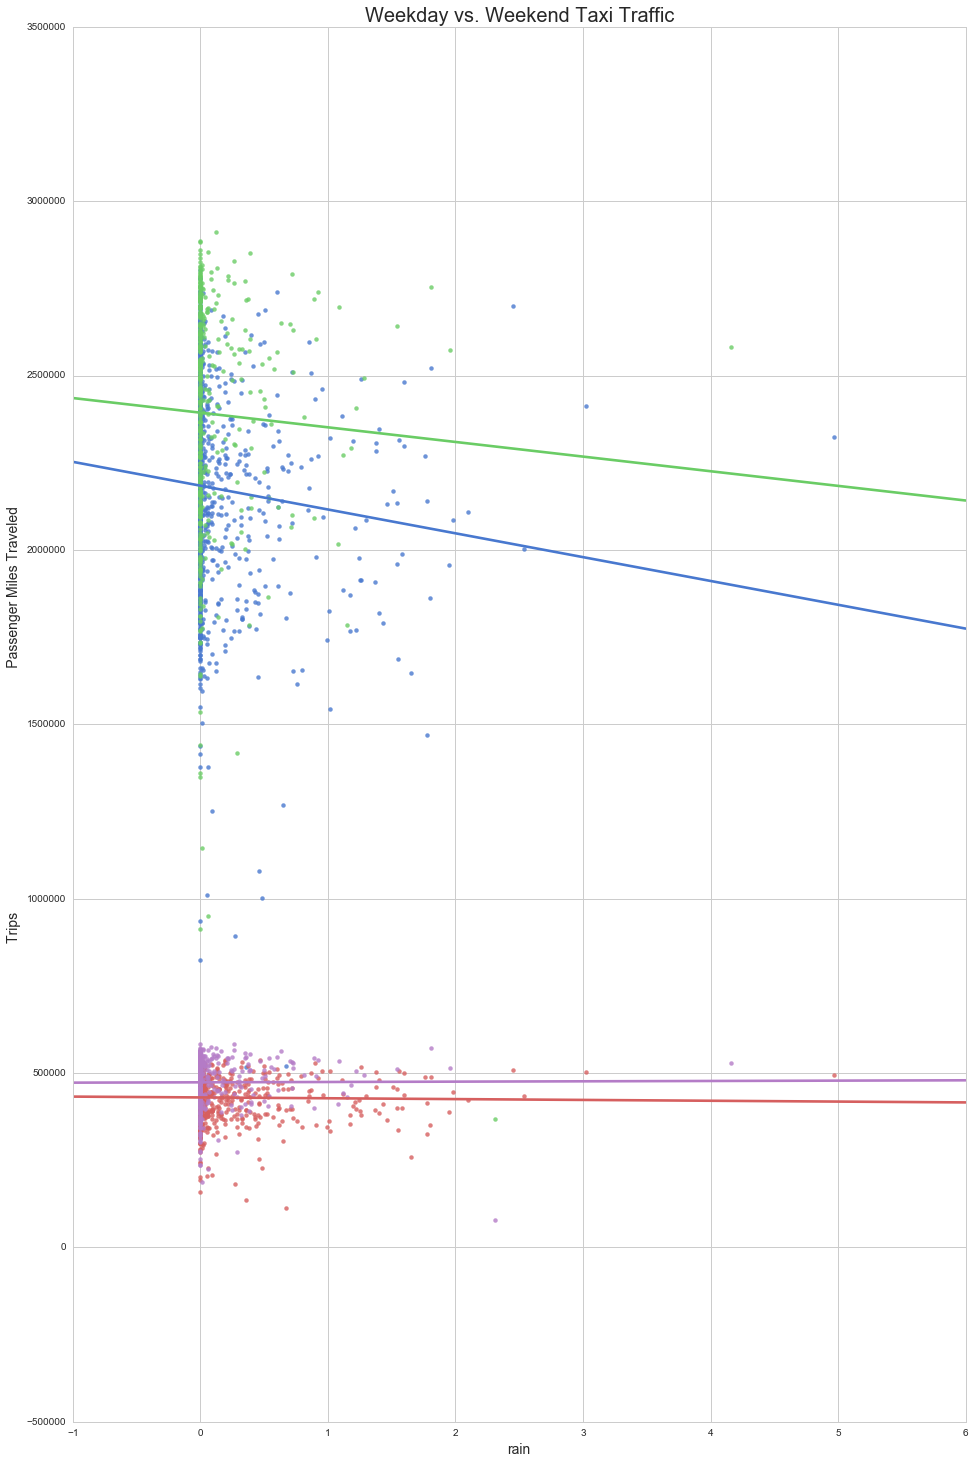

In [116]:
weekends = df[df.weekday>5]
weekdays = df[df.weekday<6]
sns.set_style("whitegrid")
sns.set_palette("muted")
plt.figure(figsize=(16,25))
plt.title("Weekday vs. Weekend Taxi Traffic", fontsize=20)
sns.regplot(weekdays.rain, weekdays.pmt,  ci=None)
sns.regplot(weekends.rain, weekends.pmt,  ci=None)
sns.regplot(weekdays.rain, weekdays.trips,  ci=None)
sns.regplot(weekends.rain, weekends.trips,  ci=None)
plt.xlabel("rain", fontsize=14)
plt.ylabel("Trips                                                               Passenger Miles Traveled", fontsize=14)
plt.show()

### As we can see from this last plot, on weekends and weekdays the number of passenger miles trends downward with rain, while the number of trips in a given day remains stable as rain increases. 

## The amount of room between the CDFs suggests that weekend and weekday traffic should be treated as separate samples. 
## pmt and trips are almost perfectly normally distributed and highly correlated. 

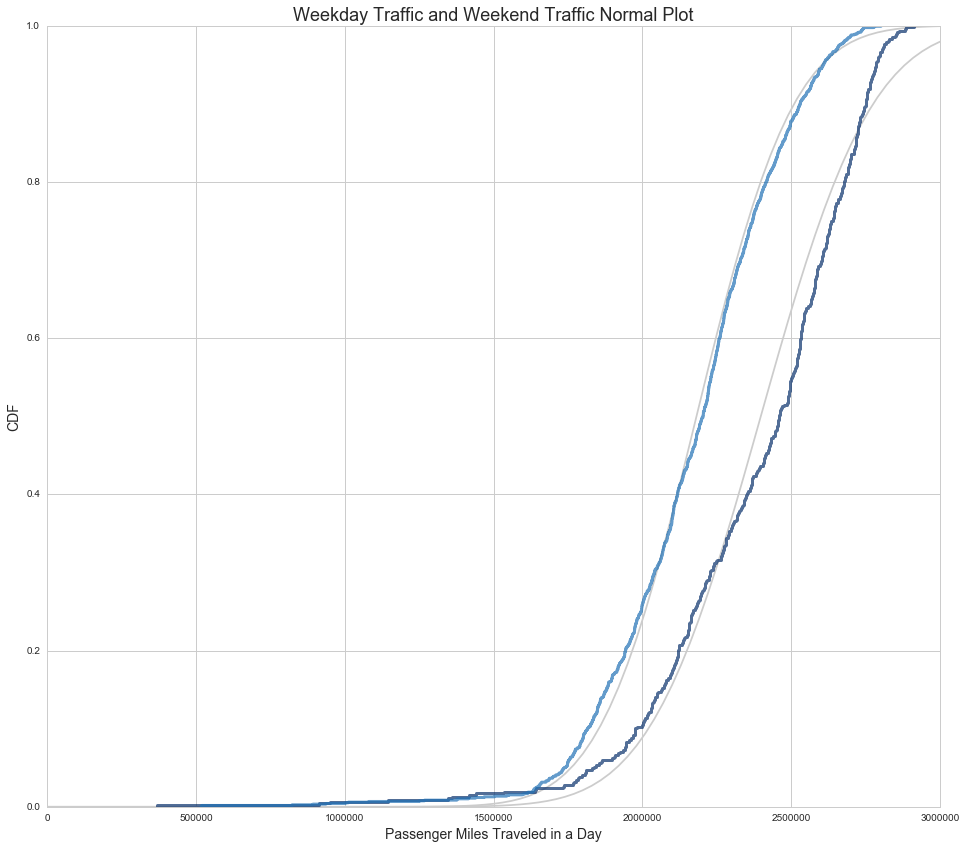

In [117]:
data1 = weekdays.pmt
mu1, var1 = ts2.TrimmedMeanVar(data1, p=0.01)

data2 = weekends.pmt
mu2, var2 = ts2.TrimmedMeanVar(data2, p=0.01)

# plot the models
sigma1 = math.sqrt(var1)
xs1, ps1 = ts2.RenderNormalCdf(mu1, sigma1, low=0, high=3000000)
weekday_cdf = ts2.Cdf(data1)

sigma2 = math.sqrt(var2)
xs2, ps2 = ts2.RenderNormalCdf(mu2, sigma2, low=0, high=3000000)
weekend_cdf = ts2.Cdf(data2)

plt.figure(figsize=(16,14))
plt.plot(xs1, ps1, color='0.8')
plt.plot(xs2, ps2, color='0.8')

#parameters for the resulting graph:
plt.title("Weekday Traffic and Weekend Traffic Normal Plot", fontsize=18)
plt.xlabel("Passenger Miles Traveled in a Day", fontsize=14)
plt.ylabel("CDF", fontsize=14)
# plot the data
tp.Cdf(weekend_cdf)
tp.Cdf(weekday_cdf)
plt.show()

## Feature Selection: 
### I've transformed the data to include the number of passenger miles traveled per day i.e. (Σ(number of passengers per trip*length of trip)) as well as a simple count of trips per day. It would be useful to understand how similar are the two metrics.

### Checking the Pearson's Correlation between PMT and trips

In [118]:
pmt_frame = df[df.pmt>0]
data = pmt_frame.pmt, pmt_frame.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(pmt_frame.pmt, pmt_frame.trips)
print(correlation)
print(pvalue)

0.886641963833
0.0


### I was unsure whether normalizing the values would influence the result of the Pearson's correlation.

In [151]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
scaled_trips = min_max_scaler.fit_transform(df.trips)
scaled_pmt = min_max_scaler.fit_transform(df.pmt)

C:\Users\J.X\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\J.X\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\J.X\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature o

### To demonstrate how similar are the two metrics:

In [120]:
from bokeh.charts import TimeSeries, show

data = dict(trips=scaled_trips, pmt=scaled_pmt, date=df.date)

tsline = TimeSeries(data,
    x='date', y=['trips','pmt'],
    color=['blue', 'green'],
    title="PMT vs Trips", ylabel='Passenger Miles Traveled', legend=True, plot_width=800)

show(tsline)

### At times, the number of trips drops or rises more precipitously than the number of passenger miles traveled and vice versa. This suggests that the 'trips' metric fails to capture some changes in traffic patterns that would result from the number of passengers increasing or decreasing during periods.

### It turns out that checking the Pearson's Correlation on Normalized Values Gives Exactly the Same Answer.

In [121]:
data = scaled_pmt, scaled_trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(scaled_pmt, scaled_trips)
print(correlation)
print(pvalue)

0.886641963833
0.0


## Plot the time series for weekend and weekday traffic along with the means
### It becomes clear that weekend values are consistently higher than weekday values. With more tests, it could make sense to look at them as two separate samples.

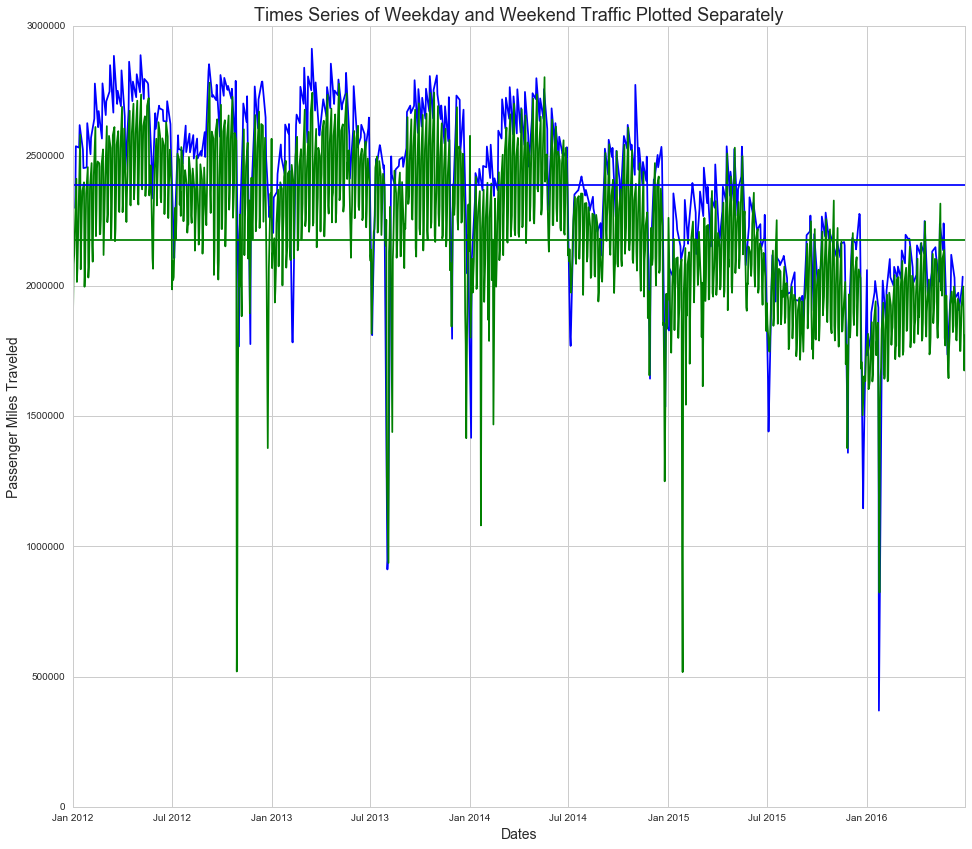

In [122]:
fig = plt.figure(figsize=(16,14))
plt.plot_date(weekends.date, weekends.pmt, 'b-')
plt.plot_date(weekdays.date, weekdays.pmt, 'g-')
plt.axhline(y=weekends.pmt.mean(), color='blue', linestyle='-')
plt.axhline(y=weekdays.pmt.mean(), color='green', linestyle='-')
plt.title("Times Series of Weekday and Weekend Traffic Plotted Separately", fontsize=18)
plt.xlabel("Dates", fontsize=14)
plt.ylabel("Passenger Miles Traveled", fontsize=14)
plt.show()

fig.autofmt_xdate()

# Hypothesis
## There is a statistically significant difference between the sample of entries from weekday and weekend traffic.
### Step 1: Check whether the difference between the means of the samples is statistically signficant.
### Check both metrics: pmt and trips
### Null Hypothesis: The factors affecting both samples are the same; treating them as one sample should not result in different means.

In [123]:
weekends = df[df.weekend==1]
weekdays = df[df.weekend==0]
saturdays = df[df.weekday==6]
sundays = df[df.weekday==7]

In [124]:
data = weekends.pmt, weekdays.pmt
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = weekdays.pmt.mean()-weekends.pmt.mean()
print(difference_in_means)
print(pvalue)

-213009.42817966873
0.0


In [125]:
data = weekends.trips, weekdays.trips
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = weekdays.trips.mean()-weekends.trips.mean()
print(difference_in_means)
print(pvalue)

-43750.96880705585
0.0


### In order to be thorough, I will also check the difference between Saturday and Sunday. There is a possibility that traffic on separate days is different in some meaningful way.

In [126]:
data = saturdays.pmt, sundays.pmt
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = saturdays.pmt.mean()-sundays.pmt.mean()
print(difference_in_means)
print(pvalue)

-56986.30769230751
0.062


In [127]:
data = saturdays.trips, sundays.trips
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = saturdays.trips.mean()-sundays.pmt.mean()
print(difference_in_means)
print(pvalue)

-1944734.6965811965
0.783


### There is a statistically significant difference between weekend and weekday traffic according to both measures - pmt and trips. For weekends the earlier trend holds. There are differences when the number of passenger miles traveled per day are measured, but these differences are either minimal or non-existent when measuring the number of trips. The difference for 'pmt' falls just short of being statistically significant, so unless more evidence presents, the sample of weekend traffic will be treated as homogeneous. 

# Hypothesis
## There is a statistically significant correlation between the amount of rain and yellow taxi traffic.

### Checking the Pearson's correlation between rainfall and weekend taxi traffic.

In [128]:
weekend_pmt = weekends.dropna(subset=['rain', 'pmt'])
data = weekend_pmt.rain, weekend_pmt.pmt
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(weekend_pmt.rain, weekend_pmt.pmt)
print(correlation)
print(pvalue)

-0.0419566169949
0.354


In [129]:
weekend_trips = weekends.dropna(subset=['rain', 'trips'])
data = weekend_trips.rain, weekend_trips.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(weekend_pmt.rain, weekend_pmt.trips)
print(correlation)
print(pvalue)

0.00457505504644
0.907


### Although there's no statistically significant correlation between weekend trips or passenger miles traveled and the amount of rain, there was a notable (although just short of stastistical significance) difference between Saturday and Sunday means. It makes sense to split the data between Saturdays and Sundays.
### What if we check the correlation separately for Saturdays and Sundays?

### Saturdays:

In [130]:
data = saturdays.rain, saturdays.pmt
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(saturdays.rain, saturdays.pmt)
print(correlation)
print(pvalue)

0.067523299609
0.293


In [131]:
data = saturdays.rain, saturdays.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(saturdays.rain, saturdays.trips)
print(correlation)
print(pvalue)

0.100764719794
0.111


### Sundays:

In [132]:
data = sundays.rain, sundays.pmt
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(sundays.rain, sundays.pmt)
print(correlation)
print(pvalue)

-0.175939782859
0.018


In [133]:
data = sundays.rain, sundays.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(sundays.rain, sundays.trips)
print(correlation)
print(pvalue)

-0.116794180586
0.065


### There is a statistically significant, although small, correlation between passenger miles traveled and rain, but not between trips and rain. So that's the metric I will continue to examine.

### Checking the Pearson's correlation between rainfall and weekday traffic:

In [134]:
weekdays = df[df.weekend==0]
data = weekdays.rain, weekdays.pmt
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(weekdays.rain, weekdays.pmt)
print(correlation)
print(pvalue)

-0.0848779145667
0.007


In [135]:
data = weekdays.rain, weekdays.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(weekdays.rain, weekdays.trips)
print(correlation)
print(pvalue)

-0.0141014612457
0.663


### There is a statistically significant correlation between passenger miles traveled and rain, while the relationship practically does not exist for trips. This reinforces the idea that pmt as a metric holds some information not present when measuring traffic using the number of trips.

## So Let's plot Taxi traffic against rainfall for weekdays and for Sundays:

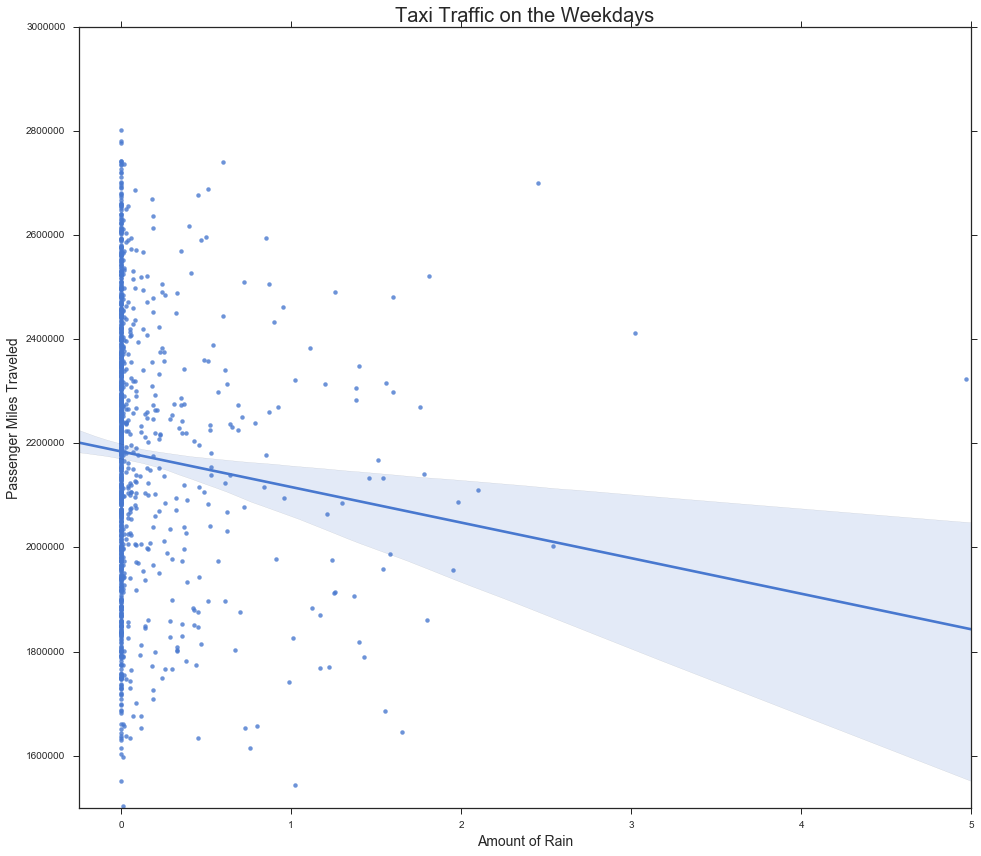

In [136]:
weekends = df[df.weekday<6]
x1 = weekdays.rain
y1 = weekdays.pmt

plt.figure(figsize=(16,14))
sns.set_palette("muted")
sns.set_style("ticks")
sns.regplot(x1, y1, ci=90)
plt.title("Taxi Traffic on the Weekdays", fontsize=20)
plt.xlabel("Amount of Rain", fontsize=14)
plt.ylabel("Passenger Miles Traveled", fontsize=14)
plt.axis([-0.25, 5, 1500000, 3000000])
plt.show()

### When we look only at Sundays, we have about 1/5 as many data points. Therefore, it is much harder to say that the perceived effect is not produced by chance. The 90 percent confidence region shows that the slope of the line could be either positive or negative.

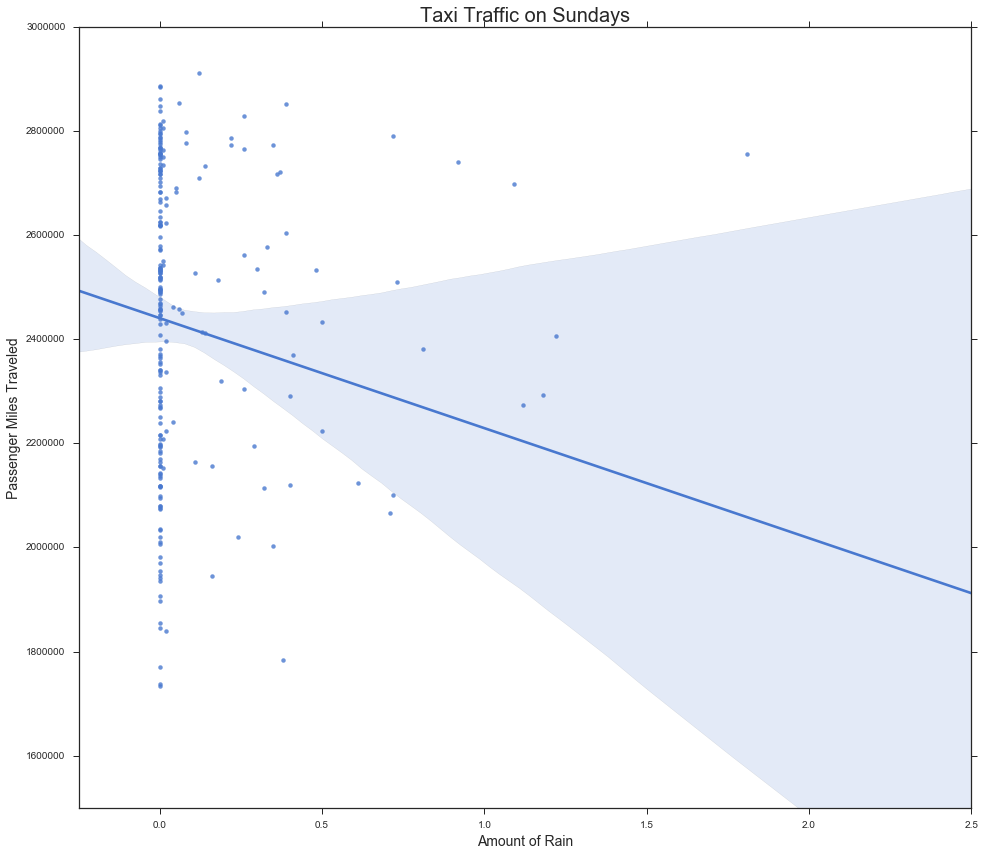

In [137]:
x1 = sundays.rain
y1 = sundays.pmt

plt.figure(figsize=(16,14))
sns.set_palette("muted")
sns.set_style("ticks")
sns.regplot(x1, y1, ci=90)
plt.title("Taxi Traffic on Sundays", fontsize=20)
plt.xlabel("Amount of Rain", fontsize=14)
plt.ylabel("Passenger Miles Traveled", fontsize=14)
plt.axis([-0.25, 2.5, 1500000, 3000000])
plt.show()

### We can try to correct for measurement error or sampling bias by plotting the linear regression for a number of samples after resampling with replacement. There's not enough data to support the relationship on weekends, but we can verify the relationship for weekdays.

In [138]:
def SamplingDistributions(data, iters=101):
    t = [] 
    for _ in range(iters):
        sample = ts2.ResampleRows(data)
        rain = sample.rain
        pmt = sample.pmt
        estimates = ts2.LeastSquares(rain, pmt)
        t.append(estimates)
    
    inters, slopes = zip(*t)
    return inters, slopes, estimates

def Summarize(estimates, actual=None):
    mean = ts2.Mean(estimates)
    stderr = ts2.Std(estimates, mu=actual)
    cdf = ts2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('Mean: ', mean)
    print('Standard Error: ', stderr)
    print('Confidence Interval: ', ci )

def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    plt.figure(figsize=(16,14))
    plt.title("90 Percent Confidence for Weekday Taxi Traffic", fontsize=20)
    plt.xlabel("Rain in Inches", fontsize=14)
    plt.ylabel("Passenger Miles Traveled", fontsize=14)
    plt.axis([-0.25, 5, 1400000, 2400000])
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = ts2.FitLine(xs, inter, slope)
        fys_seq.append(fys)
    
    p = (100-percent) / 2
    percents = p, 100-p
    low, high = ts2.PercentileRows(fys_seq, percents)
    tp.FillBetween(fxs, low, high, **options)
    weekends = df[df.weekday<6]
    x1 = weekdays.rain
    y1 = weekdays.pmt
    fit1 = np.polyfit(x1, y1, deg=1)
    plt.plot(x1, fit1[0] * x1 + fit1[1], color='red')
    tp.Show()

In [139]:
inters, slopes, estimates = SamplingDistributions(weekdays)

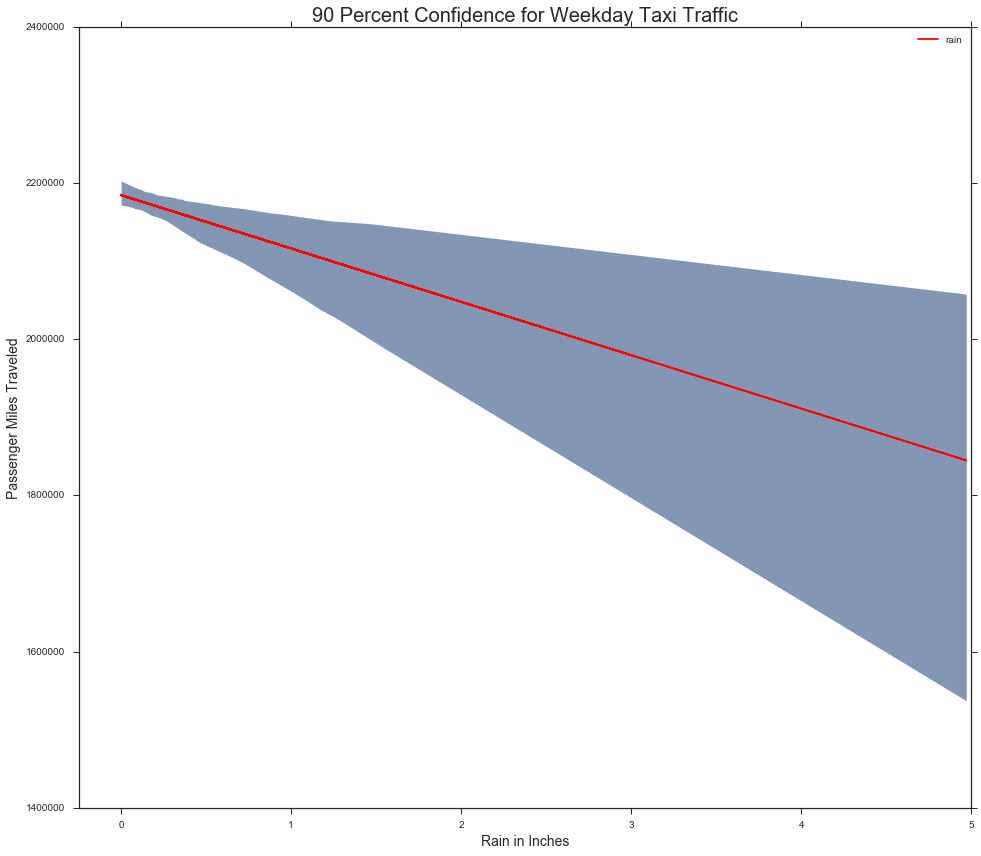

In [152]:
PlotConfidenceIntervals(weekdays.rain, inters, slopes, percent=90)

### We must modify the slope test to check for instances where the slope is less than the measured test statistic rather than greater. Our slope is negative, so every instance of a greater downward slope that occurs by chances raises the p-value.

In [141]:
class SlopeTest(ts2.HypothesisTest):
    def TestStatistic(self, data):
        rain, pmt = data
        _, slope = ts2.LeastSquares(rain, pmt)
        return slope
    
    def MakeModel(self):
        _, pmt = self.data
        self.ybar = pmt.mean()
        self.res = pmt - self.ybar
        
    def RunModel(self):
        rain, _ = self.data
        pmt = self.ybar + np.random.permutation(self.res)
        return rain, pmt
    
    def PValue(self, iters=1000):
        """Computes the distribution of the test statistic and p-value.

        iters: number of iterations

        returns: float p-value
        """
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]
        self.test_cdf = ts2.Cdf(self.test_stats)

        count = sum(1 for x in self.test_stats if x <= self.actual)
        return count / iters

In [153]:
ht = SlopeTest((sundays.rain, sundays.pmt))
pvalue = ht.PValue()
print(pvalue)

0.018


## What is the explanatory power of rain for the perceived traffic results?
### The p-value derived by simulating the null hypothesis is less than 0.015. Although the estimated slope is small, it is likely not due to chance. 

In [143]:
def SummarizeResults(results):
    """Prints the most important parts of linear regression results:
    results: RegressionResults object
    """
    for name, param in results.params.iteritems():
        pvalue = results.pvalues[name]
        print('%s   %0.3g   (%.3g)' % (name, param, pvalue))

    try:
        print('R^2 %.4g' % results.rsquared)
        ys = results.model.endog
        print('Std(ys) %.4g' % ys.std())
        print('Std(res) %.4g' % results.resid.std())
    except AttributeError:
        print('R^2 %.4g' % results.prsquared)

In [144]:
import statsmodels.formula.api as smf
formula = 'pmt ~ rain'
model = smf.ols(formula, weekdays)
results = model.fit()
print(results.summary())
print(results.rsquared)
SummarizeResults(results)

                            OLS Regression Results                            
Dep. Variable:                    pmt   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     8.512
Date:                Mon, 19 Dec 2016   Prob (F-statistic):            0.00360
Time:                        15:41:35   Log-Likelihood:                -16425.
No. Observations:                1175   AIC:                         3.285e+04
Df Residuals:                    1173   BIC:                         3.286e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.184e+06   8805.653    248.053      0.0

## This exercise has shown that knowing the amount of rain that falls on a particular day, to use Downey's words, "provides no substantial improvement to the predictions."

### It makes sense to use the categorical variables at our disposable, weekday and weekend, in a multiple linear regression model to see whether they have greater predictive power.

In [154]:
formula = 'pmt ~ rain +C(weekend) + C(weekday)'
model = smf.ols(formula, dataframe)
results = model.fit()
print(results.summary())
print(results.rsquared)
SummarizeResults(results)

                            OLS Regression Results                            
Dep. Variable:                    pmt   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     56.95
Date:                Mon, 19 Dec 2016   Prob (F-statistic):           3.45e-73
Time:                        16:50:30   Log-Likelihood:                -22948.
No. Observations:                1643   AIC:                         4.591e+04
Df Residuals:                    1635   BIC:                         4.596e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        2.349e+06   1.85e+04    1

### It turns out that the day of the week accounts for much more of the variability in the data than the amount of rain on a given day. It raises the predictive power of the model by a factor of more than twenty.

### I will apply the same multiple linear regression model to an expanded set of MTA data.

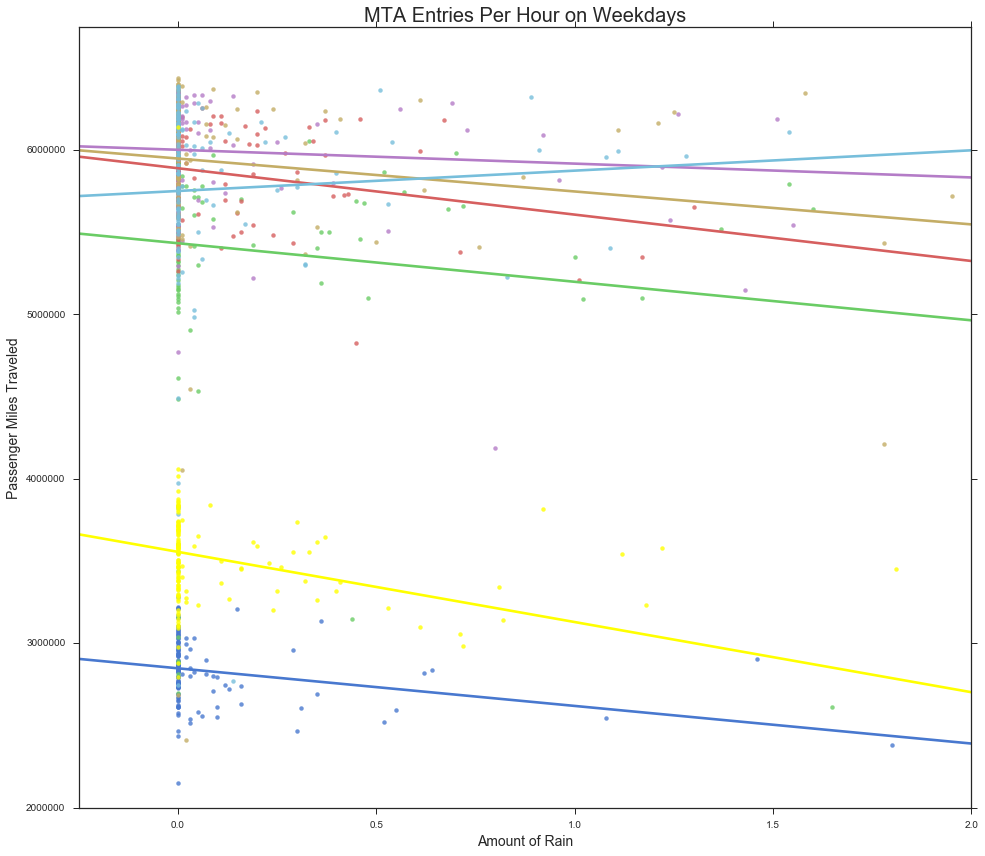

In [146]:
x1 = mta[mta.weekday==1].rain
y1 = mta[mta.weekday==1].entries
x2 = mta[mta.weekday==2].rain
y2 = mta[mta.weekday==2].entries
x3 = mta[mta.weekday==3].rain
y3 = mta[mta.weekday==3].entries
x4 = mta[mta.weekday==4].rain
y4 = mta[mta.weekday==4].entries
x5 = mta[mta.weekday==5].rain
y5 = mta[mta.weekday==5].entries
x6 = mta[mta.weekday==6].rain
y6 = mta[mta.weekday==6].entries
x7 = mta[mta.weekday==7].rain
y7 = mta[mta.weekday==7].entries

plt.figure(figsize=(16,14))
sns.set_palette("muted")
sns.set_style("ticks")
sns.regplot(x1, y1, ci=None, label="Mondays")
sns.regplot(x2, y2, ci=None, label="Tuesdays")
sns.regplot(x3, y3, ci=None, label="Wednesdays")
sns.regplot(x4, y4, ci=None, label="Thursdays")
sns.regplot(x5, y5, ci=None, label="Fridays")
sns.regplot(x6, y6, ci=None, label="Saturdays")
sns.regplot(x7, y7, ci=None, label="Sundays", color='yellow')
plt.title("MTA Entries Per Hour on Weekdays", fontsize=20)
plt.xlabel("Amount of Rain", fontsize=14)
plt.ylabel("Passenger Miles Traveled", fontsize=14)
plt.axis([-0.25, 2, 2000000, 6750000])
plt.show()

Blue = Mondays, Green = Tuesday, Red = Wednesdays, Purple = Thursdays, Orange=Friday, Teal= Saturday, Yellow = Sunday

In [148]:
formula = 'entries ~ rain +C(weekend) + C(weekday)'
model = smf.ols(formula, mta)
results = model.fit()
print(results.summary())
print(results.rsquared)
SummarizeResults(results)

                            OLS Regression Results                            
Dep. Variable:                entries   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     690.2
Date:                Mon, 19 Dec 2016   Prob (F-statistic):               0.00
Time:                        16:28:43   Log-Likelihood:                -13909.
No. Observations:                 952   AIC:                         2.783e+04
Df Residuals:                     944   BIC:                         2.787e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        2.848e+06   4.65e+04     

In [150]:
formula = 'entries ~ C(weekend) + C(weekday) + rain + snow + snowdepth'
model = smf.ols(formula, mta)
results = model.fit()
print(results.summary())
print(results.rsquared)
SummarizeResults(results)

                            OLS Regression Results                            
Dep. Variable:                entries   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     560.9
Date:                Mon, 19 Dec 2016   Prob (F-statistic):               0.00
Time:                        16:30:39   Log-Likelihood:                -13891.
No. Observations:                 952   AIC:                         2.780e+04
Df Residuals:                     942   BIC:                         2.785e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        2.852e+06   4.59e+04     